In [27]:
import seaborn as sns
import pandas as pd
from pandas.core.groupby.generic import SeriesGroupBy
from tabulate import tabulate
import numpy as np
import math

In [2]:
TIME_LIMIT = 16

In [101]:
def convert_float_to_string_percentage(p: float) -> str:
    p = 0 if math.isnan(p) else np.round(p*100, 2)
    return f'{p}%'

def count_frames_per(dataframe: pd.DataFrame, cols: list) -> pd.DataFrame:
    frames = dataframe.groupby(cols).size().to_frame(name='frames').reset_index()
    janky_frames = dataframe[dataframe.frame_time>16].groupby(cols).size().to_frame(name='janky_frames').reset_index()
    merged = frames.merge(janky_frames, how='left').fillna(0)
    merged.janky_frames = merged.janky_frames.astype(int)
    return merged

def count_frames_per_execution(dataframe: pd.DataFrame) -> pd.DataFrame:
    return count_frames_per(dataframe, ['framework', 'app', 'execution_id'])

def count_frames_per_app(dataframe: pd.DataFrame) -> pd.DataFrame:
    return count_frames_per(dataframe, ['framework', 'app'])

def get_janky_percentage(dataframe: pd.DataFrame, app: str):
    app_df = dataframe[dataframe.app==app]
    app_df = count_frames_per_execution(app_df)
    app_df['janky_percentage'] = (app_df['janky_frames'] / app_df['frames'])*100
    return app_df

def plot_janky_percentage(dataframe: pd.DataFrame, app: str):
    app_df = get_janky_percentage(dataframe, app)
    app_df['execution'] = list(range(0, 50)) + list(range(0,50))
    sns.lineplot(data=app_df, x='execution', hue='framework', y='janky_percentage')

def get_mean_and_std(dataframe: pd.DataFrame):
    per_execution_df = count_frames_per_execution(dataframe)
    per_execution_df['janky_percentage'] = (per_execution_df['janky_frames'] / per_execution_df['frames'])*100
    a = per_execution_df.groupby(['framework', 'app'])['frames'].mean().to_frame(name='frames (mean)').reset_index()
    b = per_execution_df.groupby(['framework', 'app'])['frames'].std().to_frame(name='frames (std)').reset_index()
    c = per_execution_df.groupby(['framework', 'app'])['janky_percentage'].mean().to_frame(name='janky % (mean)').reset_index()
    d = per_execution_df.groupby(['framework', 'app'])['janky_percentage'].std().to_frame(name='janky % (std)').reset_index()
    return a.merge(b).merge(c).merge(d)
    

In [69]:
df = pd.read_csv('dataframe.csv')
df = df[df.app != 'list_rec']

In [107]:
get_mean_and_std(df)

,framework,app,frames (mean),frames (std),janky % (mean),janky % (std)
0,flutter,counter,129.46,1.554585,0.309308,0.415469
1,flutter,list,357.64,7.558641,2.470240,0.853581
2,flutter,multistopwatch,358.78,8.591144,0.796664,0.318204
3,flutter,navigations,228.08,2.098007,0.737873,0.709840
4,flutter,stopwatch,359.54,17.264107,0.615006,0.355393
5,rn,counter,124.64,18.787490,0.013793,0.097532
6,rn,list,440.62,3.510276,21.342245,19.745560
7,rn,multistopwatch,268.62,7.976726,0.000000,0.000000
8,rn,navigations,192.20,1.862629,2.258425,1.552705
9,rn,stopwatch,288.52,6.048241,0.000000,0.000000


In [106]:
get_janky_percentage(df, 'stopwatch')

,framework,app,execution_id,frames,janky_frames,janky_percentage
0,flutter,stopwatch,20220723-013930,389,2,0.514139
1,flutter,stopwatch,20220723-013940,348,2,0.574713
2,flutter,stopwatch,20220723-013950,368,4,1.086957
3,flutter,stopwatch,20220723-014000,359,1,0.278552
4,flutter,stopwatch,20220723-014010,366,2,0.546448
...,...,...,...,...,...,...
95,rn,stopwatch,20220731-170847,285,0,0.000000
96,rn,stopwatch,20220731-170852,291,0,0.000000
97,rn,stopwatch,20220731-170857,291,0,0.000000
98,rn,stopwatch,20220731-170902,291,0,0.000000


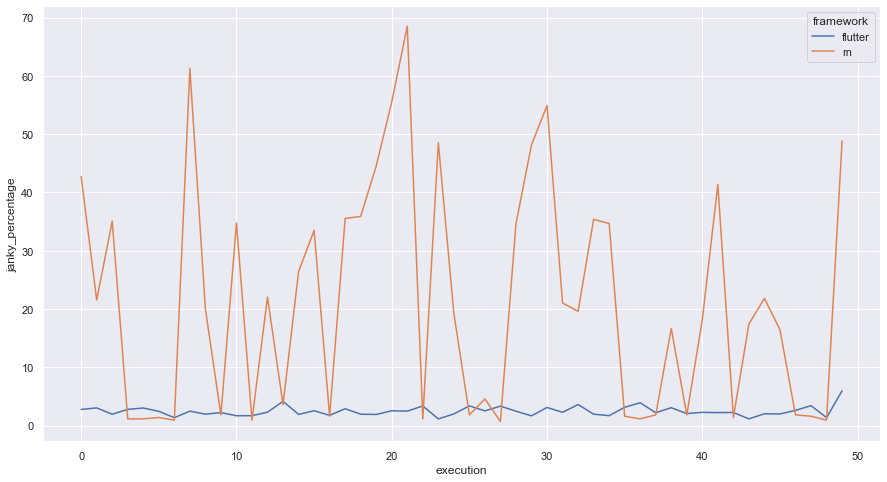

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
plot_janky_percentage(df, 'list')